# Basic data preprocessing 
### load raw files -> generate clips -> compute features-> aggregate into a matrix of features and scores
** Pandas version required to load pickle files is 0.20.1 or greater **

* Try classifying symptom presence from "typing", "walking" and "finger-to-nose" 

In [2]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt, resample
import time
import nolds
import re
import copy

# TO DO (as of 4/2/2018)
# update PreprocessFcns.py with updated functions for use in this notebook
from PreprocessFcns import *

%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [3]:
#---Pandas version required to load pickle files is 0.20.1 or greater---
pd.__version__

'0.22.0'

In [4]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'D:\CIS-PD Study\Subjects' #Windows remote path
        folder_path = r'D:\CIS-PD Study' #generic Windows repo path
        dict_path = 'D:\CIS-PD Study\Data_dict'
        scores_path = r'D:\CIS-PD Study\Scores' #remote repo
        features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
        
    elif platform.release() == '7':
        path = r'X:\CIS-PD Study\Subjects'
        folder_path = r'X:\CIS-PD Study'
#         dict_path = r'C:\Users\adai\Documents\Data_dict'
        dict_path = r'X:\CIS-PD Study\Data_dict'
        scores_path = r'X:\CIS-PD Study\Scores'
        features_path = r'X:\CIS-PD Study\FeatureMatrix'
    
else:
    path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
    folder_path = '/Volumes/RTO/CIS-PD Study/'
    dict_path = '../Data_dict' # Mac local path
    scores_path = '../Scores/' # Mac local path
    features_path = '../FeatureMatrix' # Mac local path

In [5]:
complete = list(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping',
           'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination',
           'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility',
           'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait',
           'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor',
           'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor',
           'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
           'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
           'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
           'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
           'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
           'Motor #12: Folding Towels', 'Motor #13: Sitting', 'Unstructured'])

complete_noRest = complete
complete_noRest.remove('MDS-UPDRS #11: Rest Tremor')


def process_annotations(path):
#---------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#---------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    del df['Value']
    
    df = df[(df.EventType != 'Testing Day')]
    
    sorter = set(df.EventType.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))
        
    df['EventType_Rank'] = df['EventType'].map(sorterIndex)
    df['Cycle'] = df.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['EventType_Rank']
    df[df['EventType'].str.contains('Heart')] = df[df['EventType'].str.contains('Heart')].replace(to_replace={'Cycle': {1: 'NaN', 2: 'NaN', 3: 'NaN', 4: 'NaN'}})
    df = df.reset_index(drop=True).set_index('EventType')
    
    return df

## Helper fcns

In [6]:
def extract_data(SubID, path):
#---------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#
# Outputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                     accelerometer + gyroscope or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#---------------------------------------------------------------------------------------------------------
    timestamps = process_annotations(path)
    timestamps = fix_errors(SubID, timestamps)
    timestamps = add_unstruct_data(timestamps)
    
    reverse_sensors_1024 = list(['anterior_thigh_left', 'anterior_thigh_right',
                                 'distal_lateral_shank_left', 'distal_lateral_shank_right'])
    # Hard coded list of sensors needed to be reversed in X- and Y- accel/gyro Day 1 data for Subject 1024
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith(('elec.csv', 'emg.csv', 'ecg.csv', 'ekg.csv')):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # Temporary fix for subjects missing both MDS-UPDRS #11: Rest Tremor trials, updated 4/2/2018
    if SubID in ('1024', '1030', '1032', '1053'):
        complete_acts = complete_noRest
    else:
        complete_acts = complete
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete_acts}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete_acts:
        
        startSize = timestamps.loc[activities, 'Start Timestamp (ms)']
        
        if np.size(startSize) == 1:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)']
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)']
        else:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, np.size(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, np.size(startTimestamp)):

            if np.size(startSize) == 1:
                startTime = startTimestamp
                endTime = endTimestamp
            else:
                startTime = startTimestamp[trials]
                endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]
                    
                    if SubID == '1024' and location in reverse_sensors_1024 and trials != (np.size(startTimestamp)-1):
                        data['accel'].loc[:, ('Accel X (g)')] = -1*data['accel'].loc[:, ('Accel X (g)')]
                        data['accel'].loc[:, ('Accel Y (g)')] = -1*data['accel'].loc[:, ('Accel Y (g)')]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]
                    
                    if SubID == '1024' and location in reverse_sensors_1024 and trials != (np.size(startTimestamp)-1):
                        data['gyro'].loc[:, ('Gyro X (°/s)')] = -1*data['gyro'].loc[:, ('Gyro X (°/s)')]
                        data['gyro'].loc[:, ('Gyro Y (°/s)')] = -1*data['gyro'].loc[:, ('Gyro Y (°/s)')]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps
    
    
def gen_unimodal_data(input_dict, side, unimodal_acts=None, shift=50):
#---------------------------------------------------------------------------------------------------------
# Reduces certain activities and subgroup of sensors in act_dict to only include data during active periods
# i.e right hand sensor excludes data when left hand is performing task (e.g. supination-pronation)
#
# Inputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                    accelerometer + gyroscope or accelerometer + EMG/ECG data
#         unimodal_acts - list of tasks to consider for data reduction, default value is None and uses list generated within
#                         function that cycles through all unimodal tasks. Can feed list to only look at specific subset
#         shift - shifting value of starting and ending index of reduced data. Default value is 50
#
# Outputs: act_dict - returns dictionary with appropriate tasks and sensors limited in scope to active data
#---------------------------------------------------------------------------------------------------------

    output_dict = copy.deepcopy(input_dict)
    
    if unimodal_acts and unimodal_acts is not list:
        
        raise Error("unimodal_acts must be of type list")
        
    elif not unimodal_acts:
        unimodal_acts = list(['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements'])
      
    for acts in unimodal_acts:

        for trials in range(0, len(input_dict[acts].keys())):
            
            for sensors in input_dict[acts][trials].keys():
                
                for data in input_dict[acts][trials][sensors].keys():

                    index = len(input_dict[acts][trials][sensors][data]);
                    
                    if side == 'right':
                    
                        temp_data = input_dict[acts][trials][sensors][data][shift:((index//2)-shift)];
                        output_dict[acts][trials][sensors][data] = temp_data;
                    
                    elif side == 'left':
                    
                        temp_data = input_dict[acts][trials][sensors][data][((index//2)+shift):(index-shift)];
                        output_dict[acts][trials][sensors][data] = temp_data;
                    
    return output_dict


def add_unstruct_data(input_timestamp):
#---------------------------------------------------------------------------------------------------------
# Includes unstructured activity data between tested and timestamped activities/trials in generated act_dict
# 
# Inputs: input_timestamp - timestamp after processing and fix_errors
#
# Outputs: unstructured_timestamps - timestamp dataframe with start and end timestamps for unstructured
#                                    activities. Organized within act_dict as an additional activity
#---------------------------------------------------------------------------------------------------------
    
    timestamps = input_timestamp.loc[input_timestamp.index != 'Heart Rate Variability']
    
    startTime = []; endTime = []; Cycle = []; Event = [];

    for num in range(1,6):
        startTime.append(timestamps[timestamps['Cycle']==num]['Stop Timestamp (ms)'].iat[-1])
        endTime.append(timestamps[timestamps['Cycle']==(num+1)]['Start Timestamp (ms)'].iat[0])
        Cycle.append(num)
        Event.append('Unstructured')

    d = {'EventType': Event,
         'Start Timestamp (ms)': startTime,
         'Stop Timestamp (ms)': endTime,
         'Cycle': Cycle}

    unstruct = pd.DataFrame(data=d, columns=['EventType', 'Start Timestamp (ms)', 'Stop Timestamp (ms)', 'Cycle'])
    unstruct = unstruct.set_index('EventType')
    
    unstructured_timestamps = input_timestamp.append(unstruct)
    
    return unstructured_timestamps

# Fix Error Functions

In [7]:
def fix_errors(participant, timestamps):
#input: 4 digit participant ID
# if debugFlag = 1, will execute merge function
#Output: ErrorList - A list of the errors needed to be fixed for the participant
#        timestamps - The dataFrame with the errors corrected for the participant
#        errordf - The dataFrame containing the remaining errors less the ones just fixed

    participant = int(participant) #convert to int, input SubID is a str
    errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
    errPar = errordf[errordf['Participant'] == participant]
    errorActivity = (errPar['Activity'])
    error = errPar['Error']
    cycle = errPar['Cycle']
    day = errPar['Day']
    time = errPar['Time Adjusted (sec)']
    desc = errPar['Type']
    errorAndActivity = errPar[['Error','Activity']]
    
    # Hard coded relabel for one activity in Subject 1049's timestamps
    if participant == 1049:
        for i in range(0,len(timestamps)-1):
            row = timestamps.iloc[i]
        
            if timestamps.index[i] == 'MDS-UPDRS #6: Arising from Chair' and row['Start Timestamp (ms)'] == 1505757980933:
                timestamps.reset_index(inplace=True)
                #timestamps.set_value(i, 'EventType', 'Motor #6: Sit to Stand')
                #.set_value is deprecated as of pandas 21.0, .at used instead for label-based
                timestamps.at[i, 'EventType'] = 'Motor #6: Sit to Stand'
                timestamps.set_index('EventType', inplace=True)
    
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        if errDay == 'Day 2':
            if 'MDS' in errAct:
                errCycle = errCycle + 2
            elif 'Motor' in errAct:
                errCycle = errCycle + 5

        if errType == 'Merge':
            timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Late':
            timestamps = fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Early':
            timestamps = fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Duplicate':
            timestamps = fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant)

        elif errType == 'Split':
            timestamps = fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
            
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        
        if errType == 'Absent':
            timestamps = fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
    
    
    tempappend = errordf.loc[errPar.index.values]
    #fixdf = fixdf.append(tempappend)
    errordf = errordf.drop(errPar.index.values)
    
    print('Subject ' + str(participant) + ' had ' + str(len(error)) + ' errors fixed.')

    return timestamps


def fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# subtracts time from the beginning or ending timestamp of the designated activity

    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
      
            if errType == 'End':
                startTime = startRow['Stop Timestamp (ms)']
                startTime = startTime - (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
        
            else:
                startTime = startRow['Start Timestamp (ms)']
                # print(startRow)
                # print(startTime)
                startTime = startTime - (errTime*1000)
                # print(errTime)
                # print(startTime)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
     
    return timestamps


def fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# adds time to the beginning or ending timestamp of the designated activity
    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
            
            if errType == 'End':
                startTime = startRow[1]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

            else:
                startTime = startRow[0]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

    return timestamps


def fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-2):
        nextRow = timestamps.iloc[i+1]
        startRow = timestamps.iloc[i]

        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            timeEnd = nextRow['Stop Timestamp (ms)']
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd,takeable=True)
            timestamps.iat[i,ii] = timeEnd
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            timestamps = pd.concat([timestamps.iloc[:(i+1)],timestamps.iloc[(i+2):]])

        timestamps.reset_index(inplace=True)
        timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
        timestamps.set_index('EventType',inplace=True)

    return timestamps

                

def fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timeStart1 = row['Start Timestamp (ms)']
            timeEnd2 = row['Stop Timestamp (ms)']
            timeChange = errTime
            timeEnd1 = timeStart1 + timeChange
            timeStart2 = timeEnd1
            idx = complete.index(errAct)
            ErrorActivity2 = complete[idx+1]
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd1,takeable=True)
            timestamps.iat[i,ii] = timeEnd1
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            line = pd.DataFrame({"Start Timestamp (ms)":timeEnd1,"Stop Timestamp (ms)":timeEnd2,"Cycle":errCycle},index=[ErrorActivity2])
            timestamps = pd.concat([timestamps.iloc[:(i+1)],line,timestamps.iloc[(i+1):]])
            
            timestamps.reset_index(inplace=True)
            colnames = timestamps.columns.tolist()
            colnames[colnames.index('index')] = 'EventType'
            timestamps.columns = colnames
            timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
            timestamps.set_index('EventType',inplace=True)
           
    return timestamps

            

def fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant):

    for i in range(0,len(timestamps)-2):
        row = timestamps.iloc[i]
        if participant == 1054 and timestamps.index[i] == 'Motor #8: Typing on a Computer':
            if timestamps.index[i] == errAct and row['Cycle'] == errCycle+1:
                timestamps = pd.concat([timestamps.iloc[:(i)],timestamps.iloc[(i+1):]])
            
        elif timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timestamps = pd.concat([timestamps.iloc[:i],timestamps.iloc[(i+1):]])
            
    timestamps.reset_index(inplace=True)
    timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    timestamps.set_index('EventType',inplace=True)

    return timestamps

def fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
    
    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle and errDay != 'Day 2':

            for j in range(i-1,len(timestamps)-1):
                row = timestamps.iloc[j]
                
                if timestamps.index[j] == errAct:
                    cyclenum = row['Cycle']
                    newCycle = cyclenum + 1
                    ii = timestamps.columns.get_loc('Cycle')
                    # timestamps.set_value(j,ii,newCycle,takeable=True)
                    timestamps.iat[j,ii] = newCycle
                    # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
    
    return timestamps

In [8]:
errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
errordf.head()

Participant                            Activity  Cycle       Error    Day  \
0         1004  MDS-UPDRS #9: Postural Hand Tremor    1.0       Split  Day 1   
1         1004  MDS-UPDRS #10: Kinetic Hand Tremor    1.0  Split Into  Day 1   
2         1004            Motor #4: Finger to Nose    1.0       Merge  Day 1   
3         1004            Motor #4: Finger to Nose    2.0       Merge  Day 1   
4         1004    MDS-UPDRS #6: Arising from Chair    2.0      Absent  Day 1   

   Time Adjusted (sec)        Type  
0                  5.0         NaN  
1                  NaN         NaN  
2                  NaN         NaN  
3                  NaN         NaN  
4                  NaN  Not tested

In [8]:
os.listdir(path + '/1020/anterior_thigh_left/d5la7wz0/')

['2017-08-03T17-44-51-148Z']

## Create dictionaries from sensor data from all the subjects

In [9]:
print(os.listdir(dict_path))
print(len(os.listdir(dict_path)))

['1004dict.pkl', '1016dict.pkl', '1018dict.pkl', '1019dict.pkl', '1020dict.pkl', '1024dict.pkl', '1029dict.pkl', '1030dict.pkl', '1032dict.pkl', '1038dict.pkl', '1044dict.pkl', '1046dict.pkl', '1047dict.pkl', '1049dict.pkl', '1051dict.pkl', '1052dict.pkl', '1053dict.pkl', '1054dict.pkl', '1055dict.pkl', '1056dict.pkl']
20


In [53]:
#all subj data files in repository
d = os.listdir(path)
f = [filename[0:4] for filename in d if filename.startswith('1')] #need to update to skip existing files in /data
print(f)
#existing data dictionary files
fd = os.listdir(dict_path)
fd = [x[:4] for x in fd] #ignore FX at end
print(list(set(f) - set(fd)))

#errors temporarily resolved 10/10/2017, will update later
# f.remove('1030')
# f.remove('1032')
# f.remove('1024')
# f.remove('1052')

['1038', '1016', '1020', '1030', '1029', '1051', '1047', '1052', '1044', '1055', '1024', '1019', '1018', '1054', '1053', '1056', '1046', '1049', '1032', '1004']
[]


In [81]:
#create data dict for remaining subjects
data_all = []
for SubID in list(set(f)-set(fd)):
    print('Loading Subject ' + SubID + ' Data...')
    act_dict, timestamps = extract_data(SubID, os.path.join(path, SubID))
    print('Extract data complete.')
    #save dict to Pickle file
    #filename = dict_path+'\\'+SubID + 'dict.pkl'
    filename = os.path.join(dict_path, SubID + 'dict.pkl')
    print(filename)
    f = open(filename,'wb')
    pickle.dump(act_dict,f)
    f.close()
    print(filename + ' ' + 'File Saved\n')

Loading Subject 1038 Data...
Subject 1038 had 4 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1038dict.pkl
D:\CIS-PD Study\Data_dict\1038dict.pkl File Saved

Loading Subject 1056 Data...
Subject 1056 had 8 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1056dict.pkl
D:\CIS-PD Study\Data_dict\1056dict.pkl File Saved

Loading Subject 1051 Data...
Subject 1051 had 5 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1051dict.pkl
D:\CIS-PD Study\Data_dict\1051dict.pkl File Saved

Loading Subject 1053 Data...
Subject 1053 had 6 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1053dict.pkl
D:\CIS-PD Study\Data_dict\1053dict.pkl File Saved

Loading Subject 1044 Data...
Subject 1044 had 3 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1044dict.pkl
D:\CIS-PD Study\Data_dict\1044dict.pkl File Saved

Loading Subject 1018 Data...
Subject 1018 had 2 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1018dict.pkl
D

C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Extract data complete.
D:\CIS-PD Study\Data_dict\1024dict.pkl
D:\CIS-PD Study\Data_dict\1024dict.pkl File Saved

Loading Subject 1049 Data...
Subject 1049 had 9 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1049dict.pkl
D:\CIS-PD Study\Data_dict\1049dict.pkl File Saved

Loading Subject 1052 Data...
Subject 1052 had 5 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1052dict.pkl
D:\CIS-PD Study\Data_dict\1052dict.pkl File Saved

Loading Subject 1055 Data...
Subject 1055 had 21 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1055dict.pkl
D:\CIS-PD Study\Data_dict\1055dict.pkl File Saved

Loading Subject 1019 Data...
Subject 1019 had 3 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1019dict.pkl
D:\CIS-PD Study\Data_dict\1019dict.pkl File Saved

Loading Subject 1054 Data...
Subject 1054 had 12 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1054dict.pkl
D:\CIS-PD Study\Data_dict\1054dict.pkl File Saved

Loading Su

## Explore features from individual subject 

In [40]:
#load Pickle file dict
subj = 1016
#f = open(dict_path+'/'+str(subj)+'dict.pkl','rb')
f = open(os.path.join(dict_path, str(subj) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

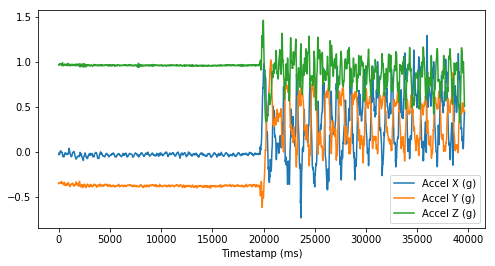

In [41]:
#choose task, trials(visits) and sensor location
# task = 'Motor #8: Typing on a Computer'
task = 'Motor #4: Finger to Nose'
# task = 'Motor #6: Sit to Stand'
# task = 'Unstructured'

# loc = 'dorsal_hand_left'
loc = 'dorsal_hand_right'
# loc = 'sacrum'
# loc = 'flexor_digitorum_left'
# loc = 'flexor_digitorum_right'
sensor = 'accel'
trial = 6
#activity dictionary structure (TASK-TRIAL-LOCATION-SENSOR)
rawdata = act_dict[task][trial][loc][sensor]
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.plot(figsize=(8,4))

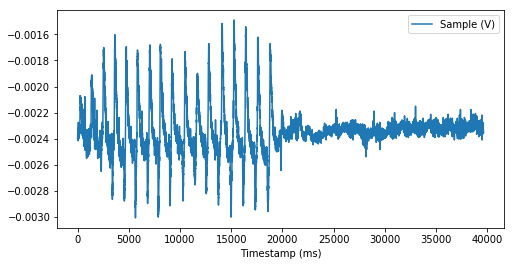

In [45]:
task = 'Motor #4: Finger to Nose'
# task = 'Motor #6: Sit to Stand'
# task = 'Unstructured'

# loc = 'dorsal_hand_left'
# loc = 'dorsal_hand_right'
# loc = 'sacrum'
# loc = 'flexor_digitorum_left'
loc = 'flexor_digitorum_right'
# loc = 'medial_chest'
sensor = 'elec'
trial = 6
#activity dictionary structure (TASK-TRIAL-LOCATION-SENSOR)
rawdata = act_dict[task][trial][loc][sensor]
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.plot(figsize=(8,4))

In [62]:
keys = act_dict[tasks].keys()
list(keys)

[0, 1, 2, 3, 4, 5, 6]

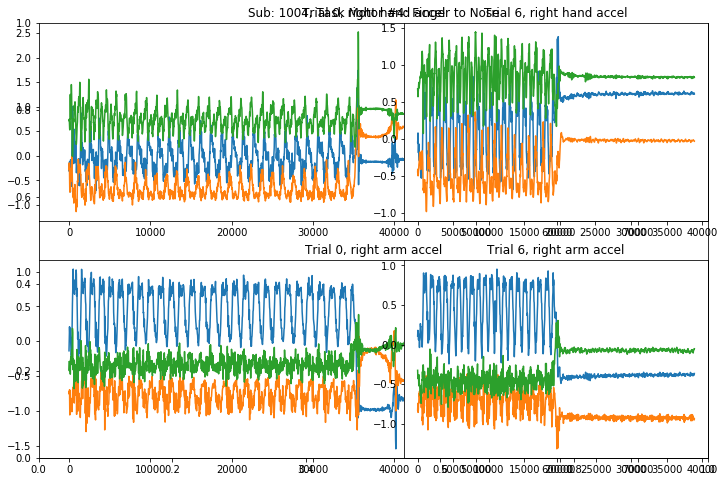

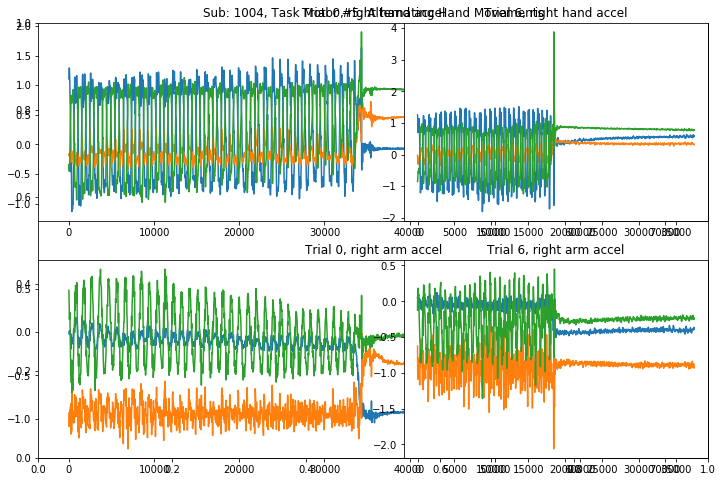

In [67]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1004
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

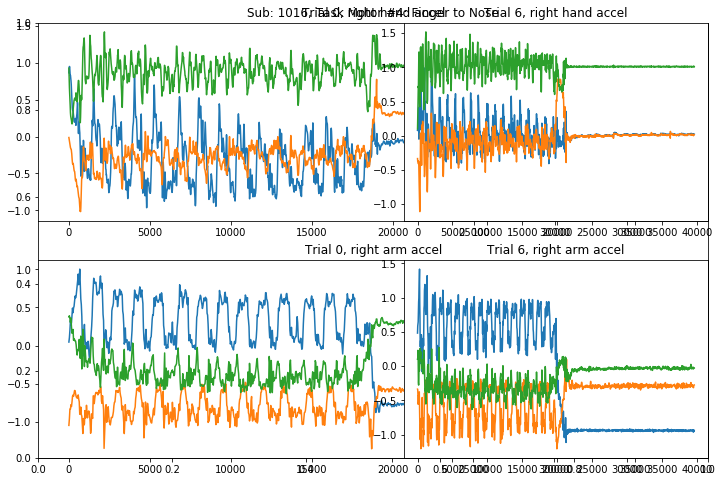

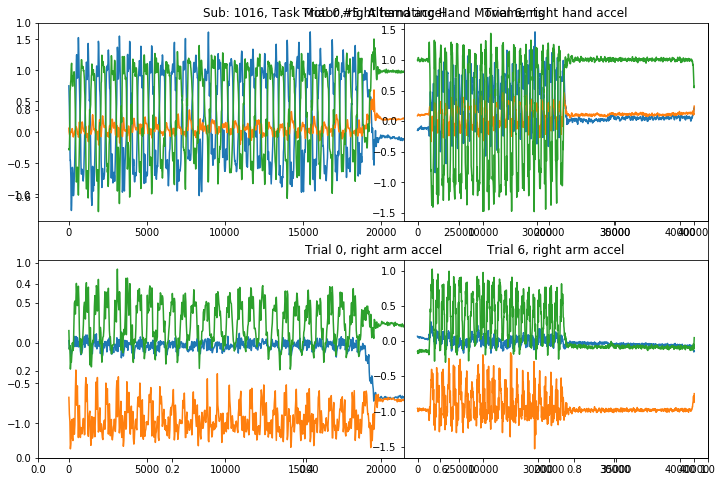

In [82]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1016
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

In [51]:
np.size(act_dict[task][trial][loc][sensor])

39628

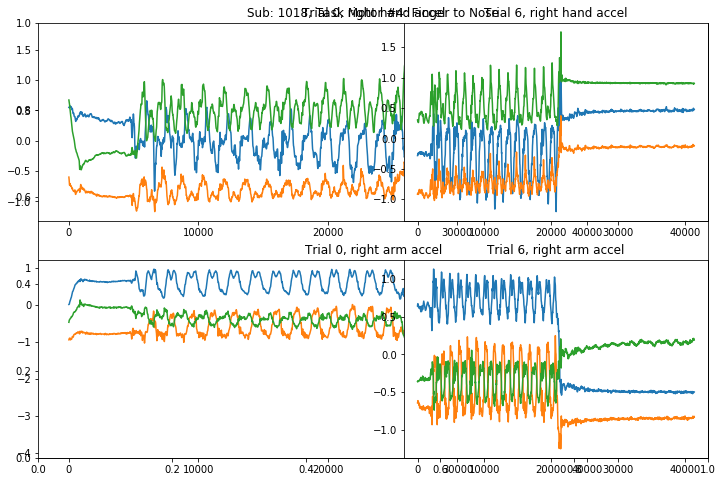

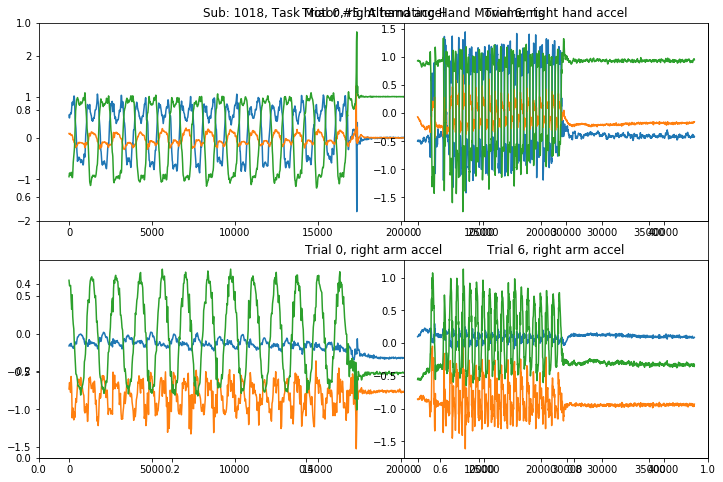

In [69]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1018
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

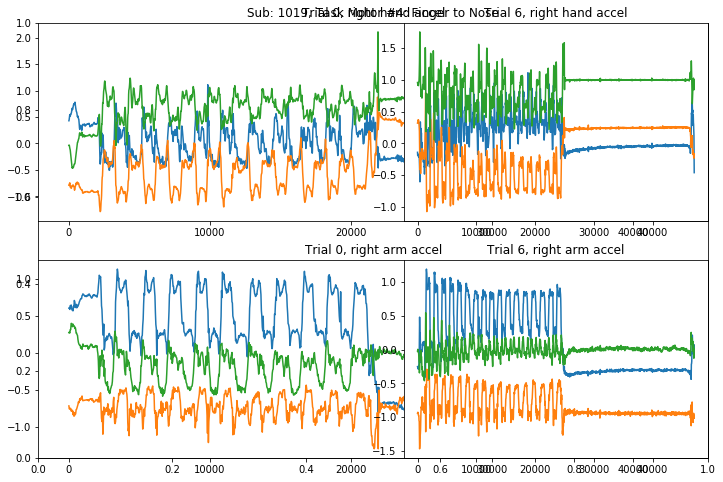

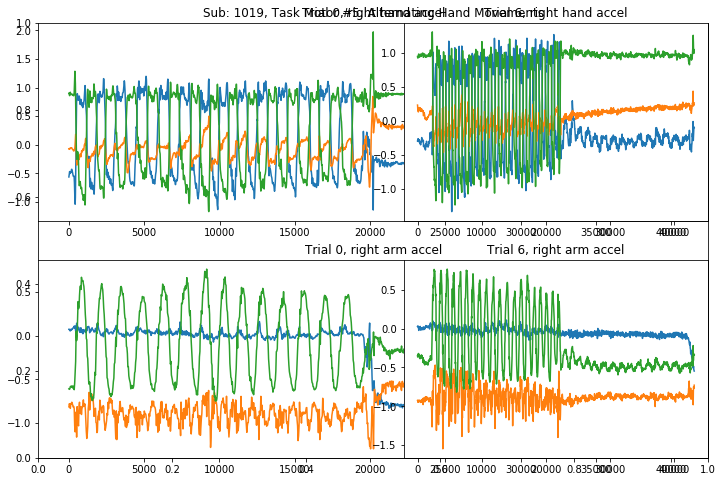

In [70]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1019
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

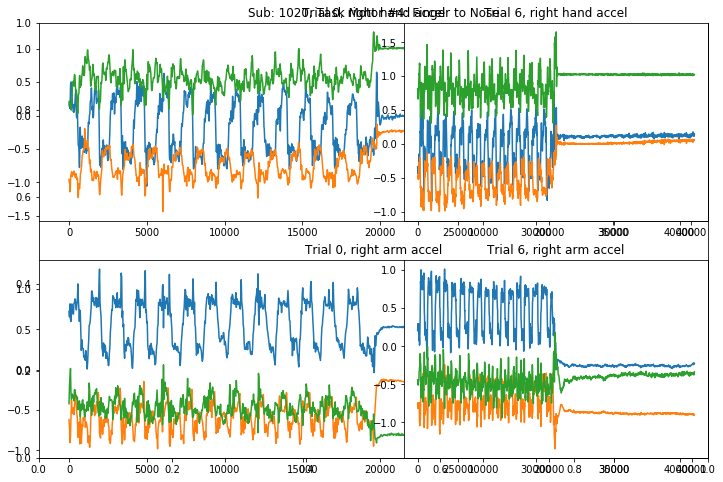

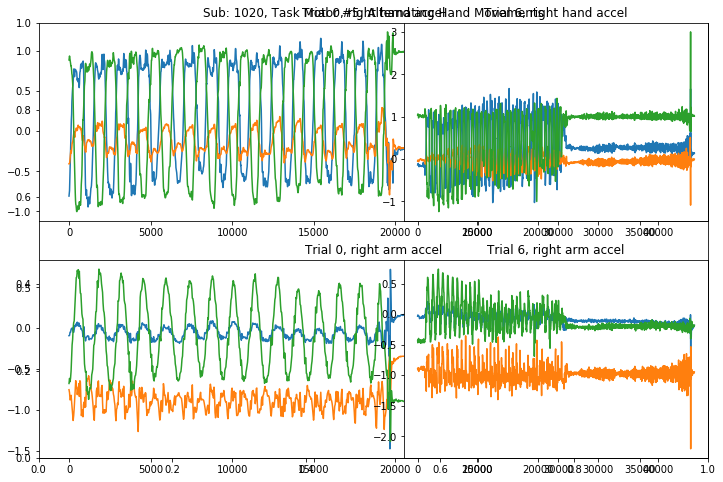

In [71]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1020
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

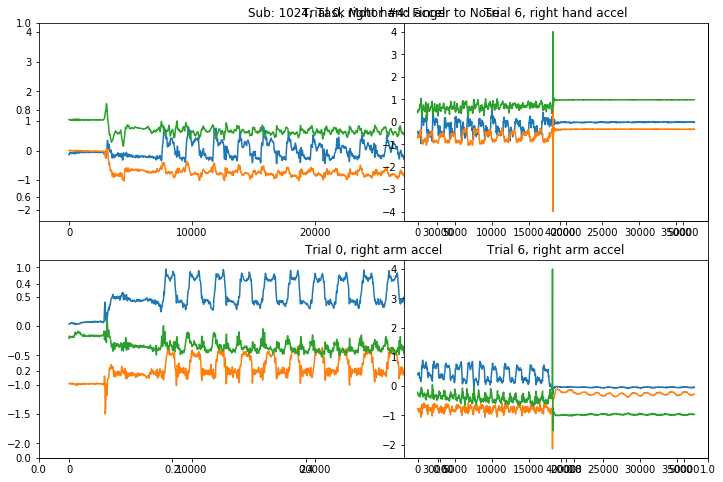

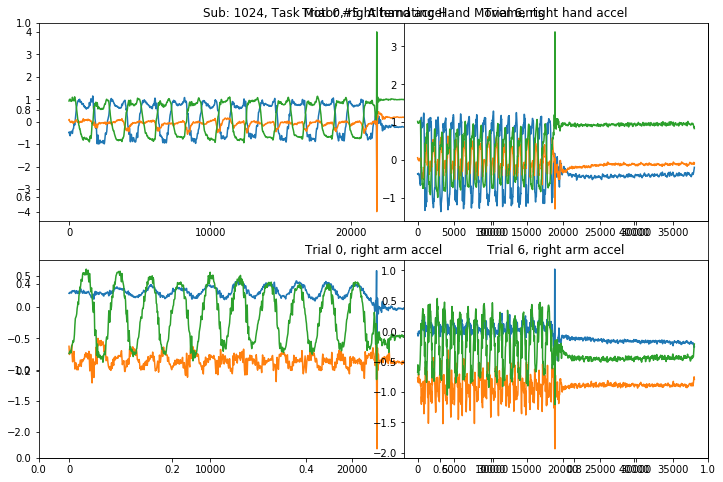

In [73]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1024
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

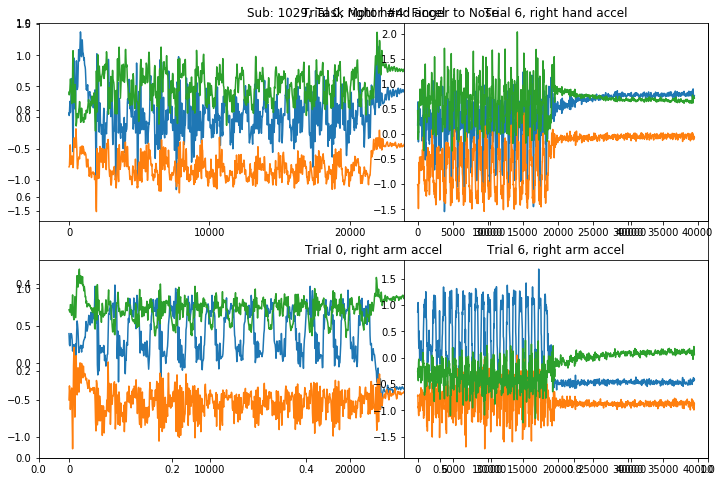

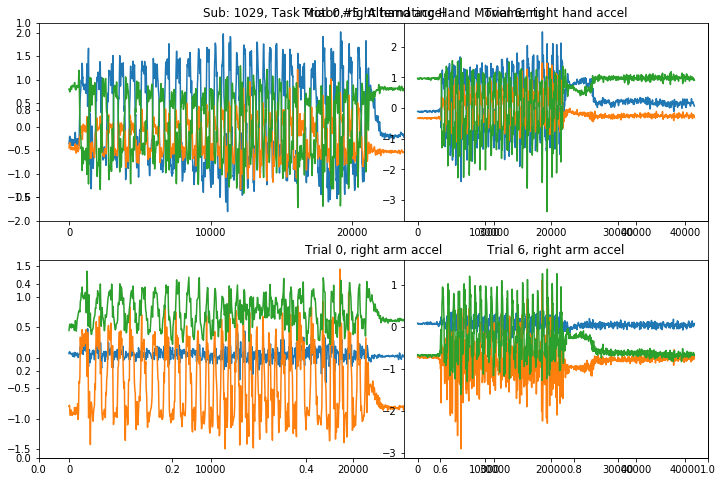

In [74]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1029
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

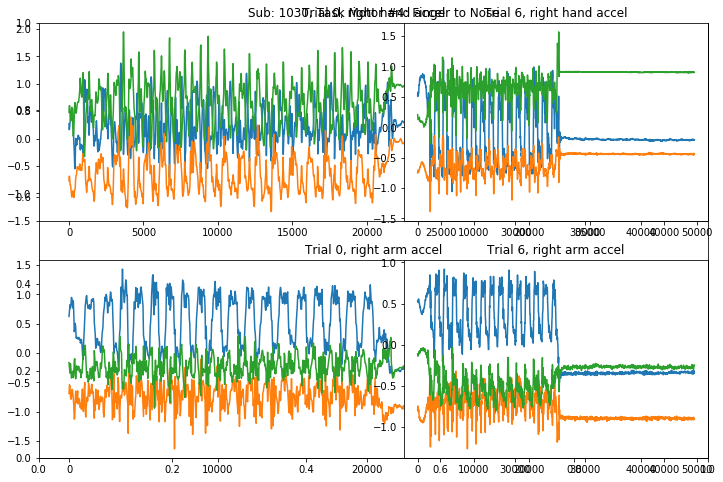

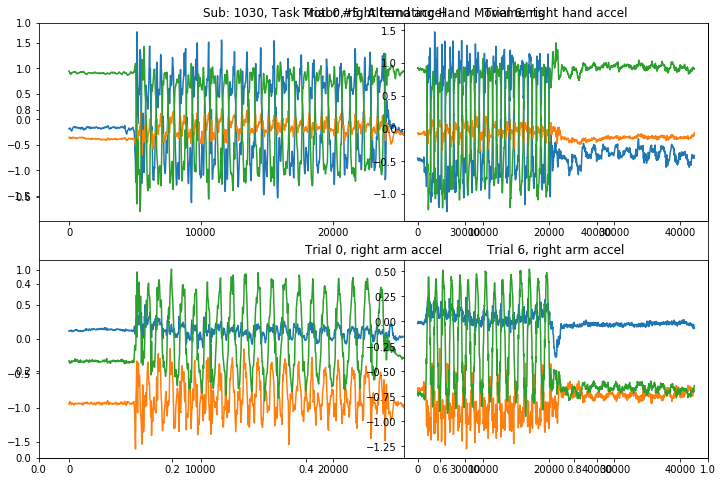

In [75]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1030
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

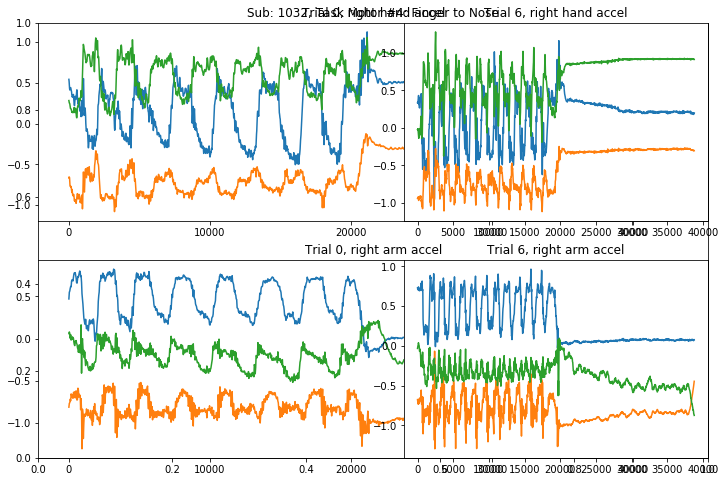

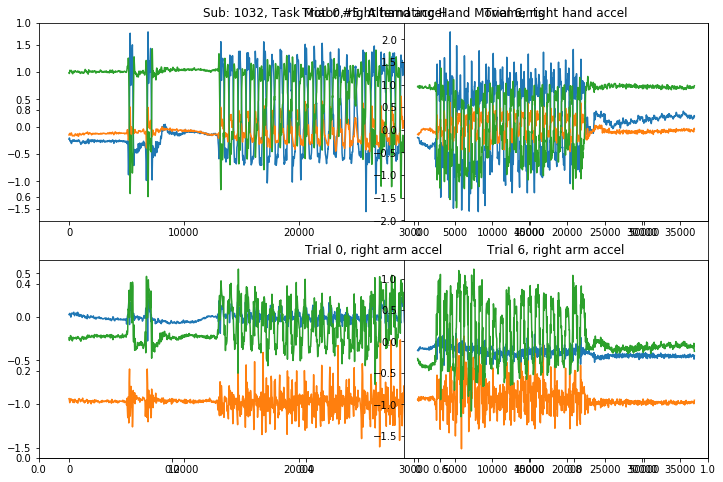

In [76]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1032
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

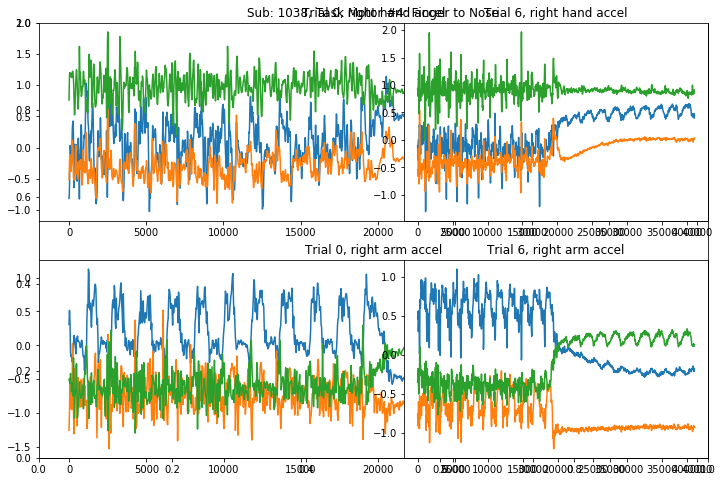

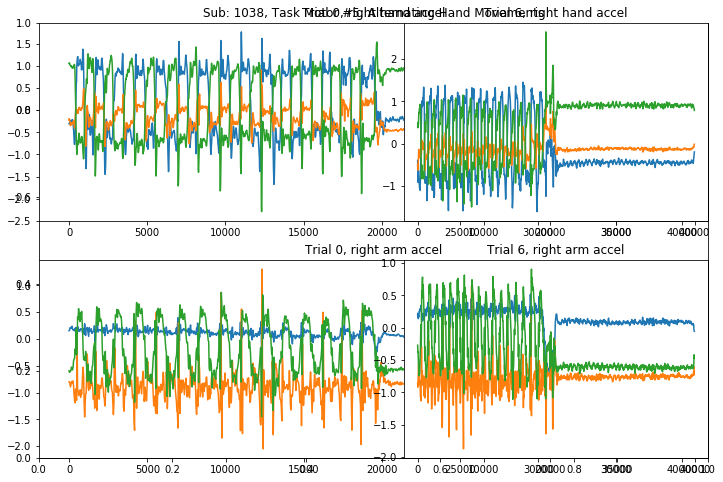

In [78]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1038
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

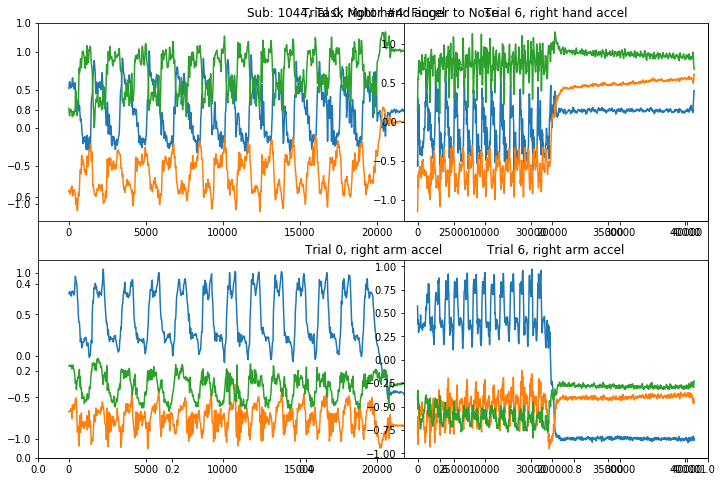

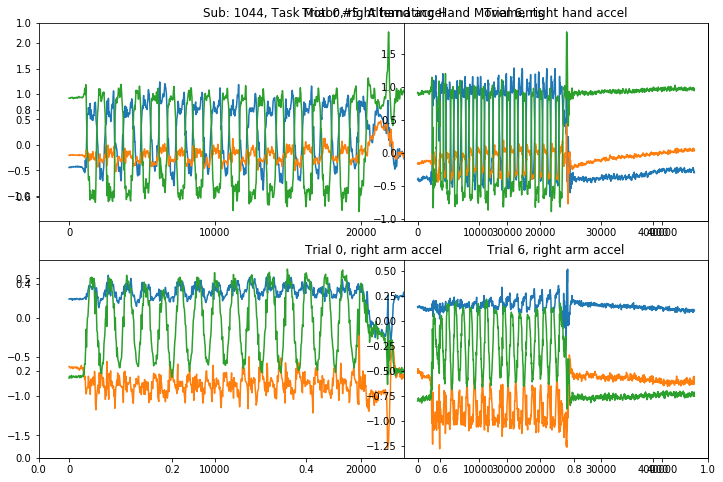

In [79]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1044
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right hand accel')

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 0, right arm accel')

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right hand accel')

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial 6, right arm accel')

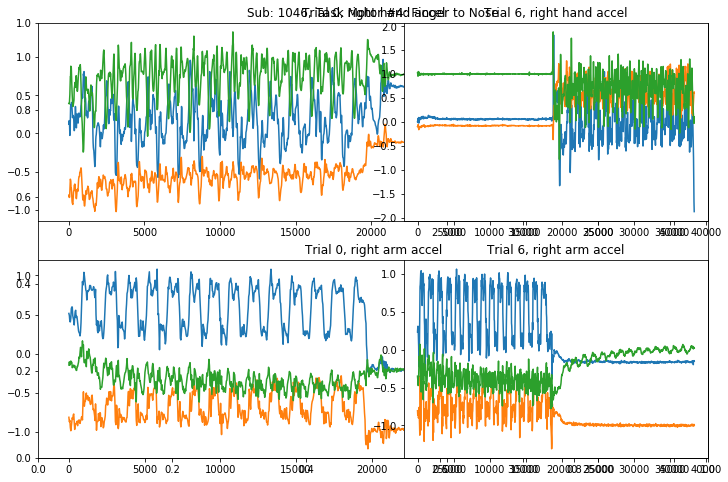

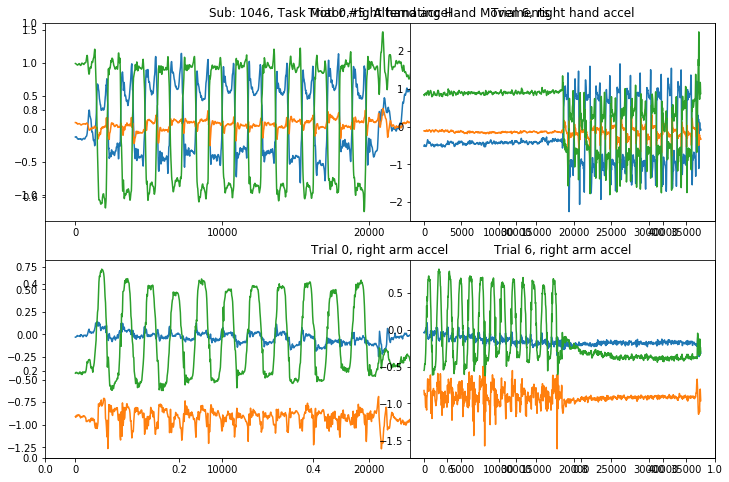

In [81]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1046
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[0])

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[0])

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[-1])

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[-1])

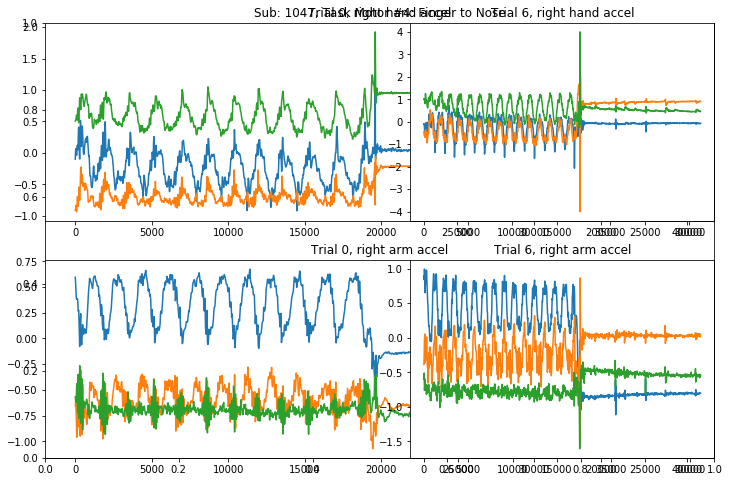

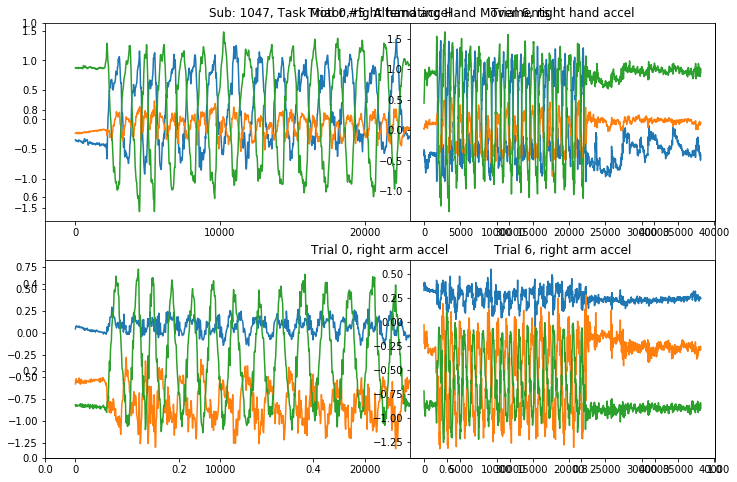

In [83]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1047
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[0])

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[0])

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[-1])

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[-1])

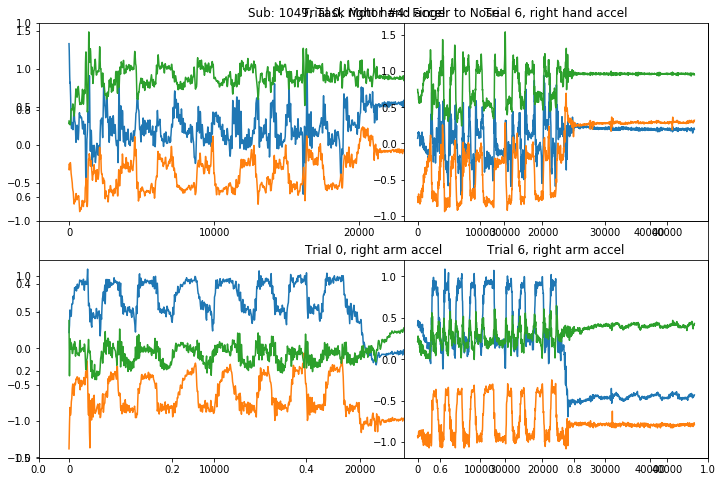

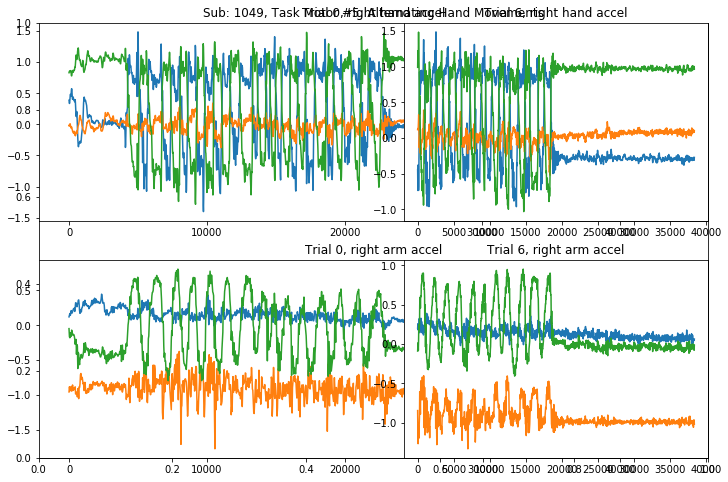

In [84]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1049
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[0])

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[0])

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[-1])

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[-1])

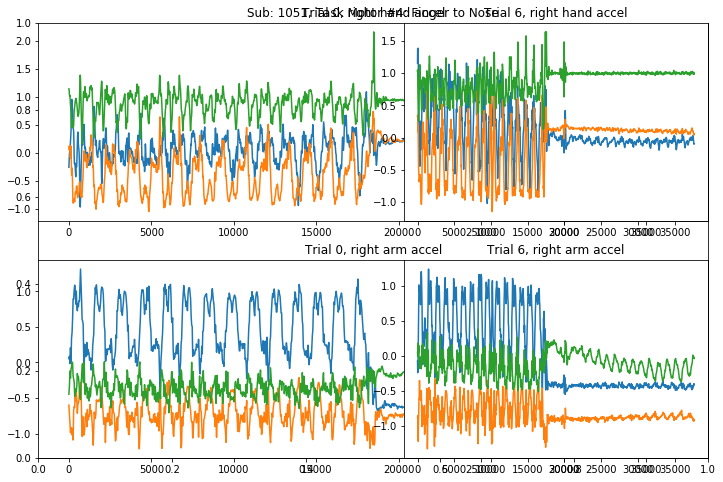

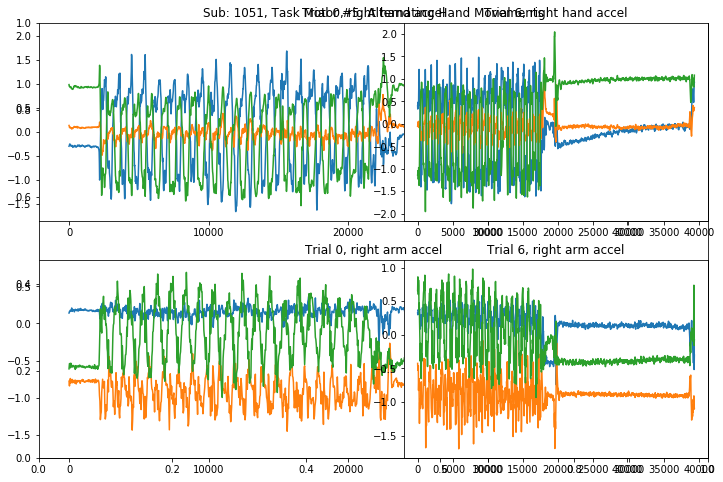

In [85]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1051
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[0])

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[0])

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[-1])

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[-1])

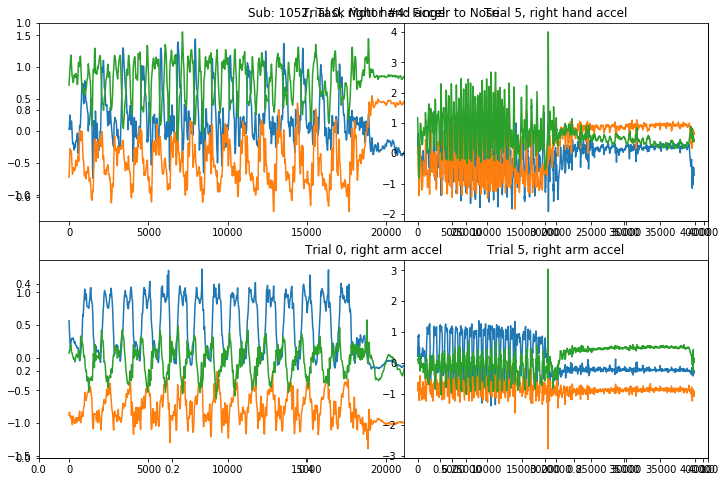

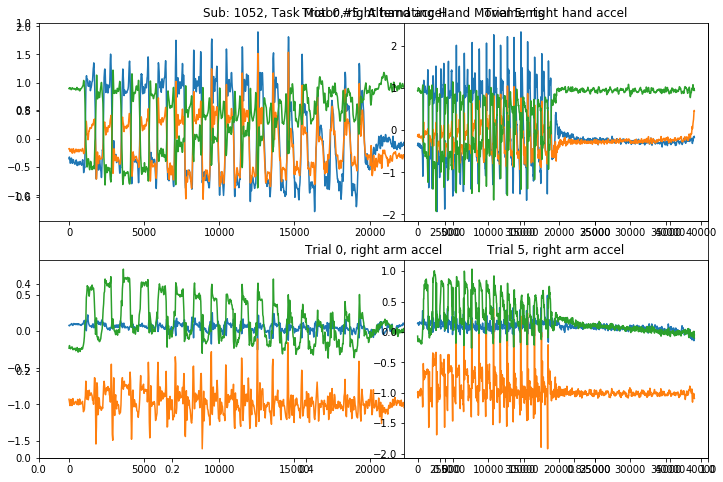

In [86]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1052
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[0])

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[0])

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[-1])

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[-1])

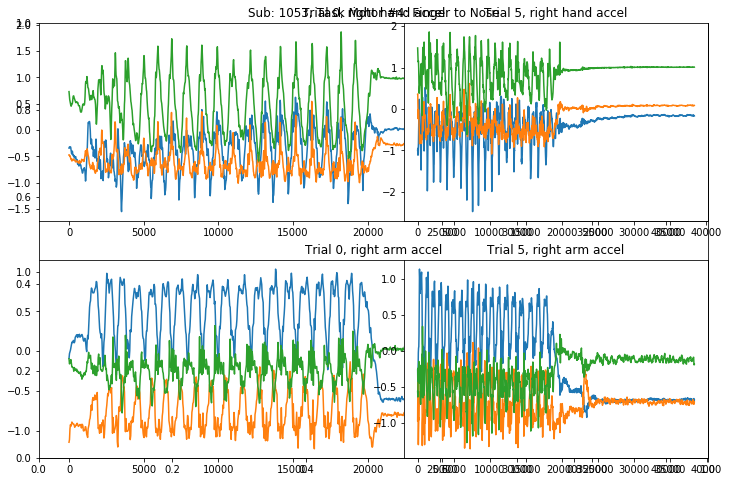

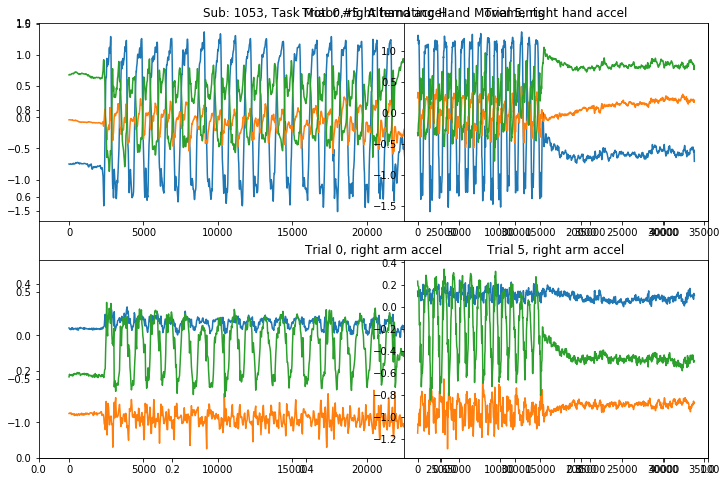

In [87]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1053
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[0])

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[0])

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[-1])

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[-1])

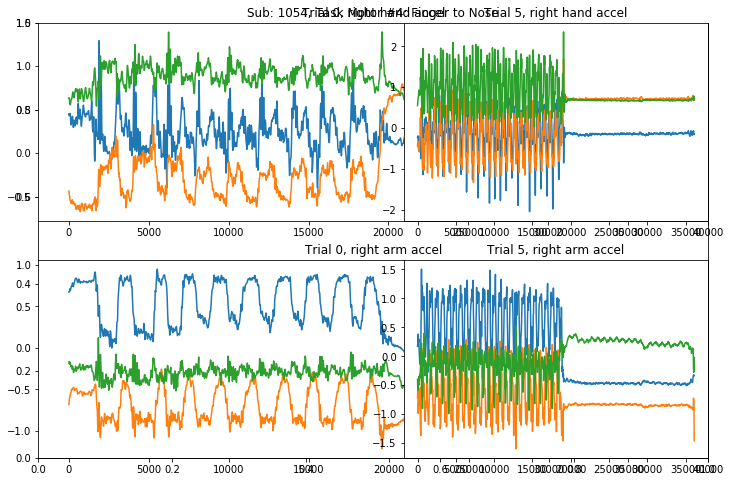

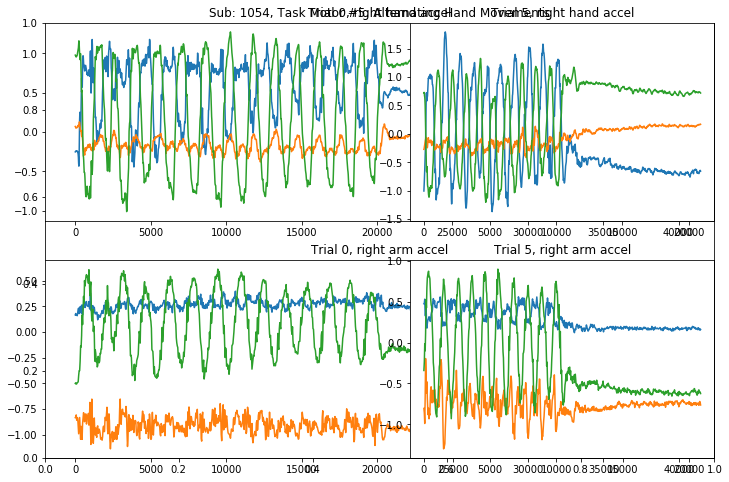

In [88]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1054
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[0])

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[0])

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[-1])

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[-1])

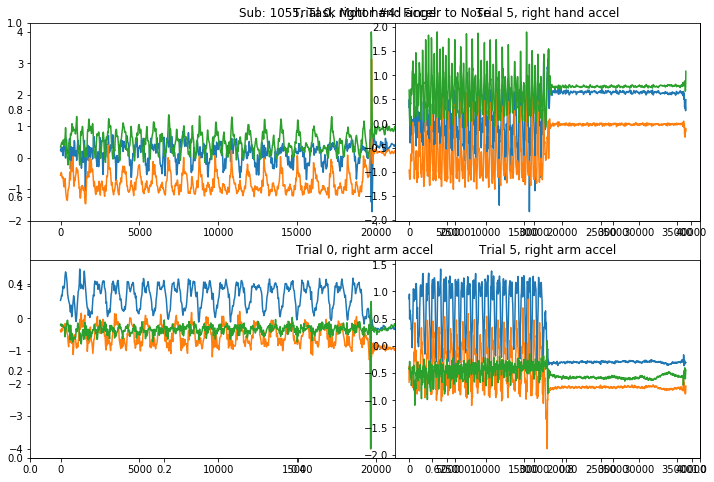

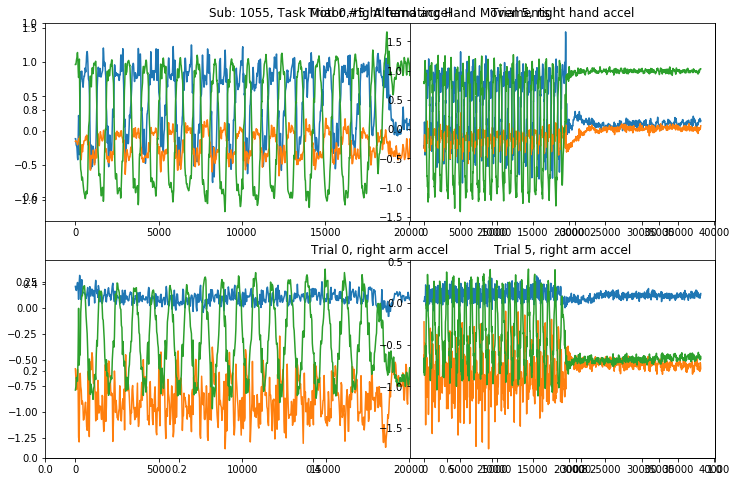

In [89]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1055
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[0])

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[0])

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[-1])

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[-1])

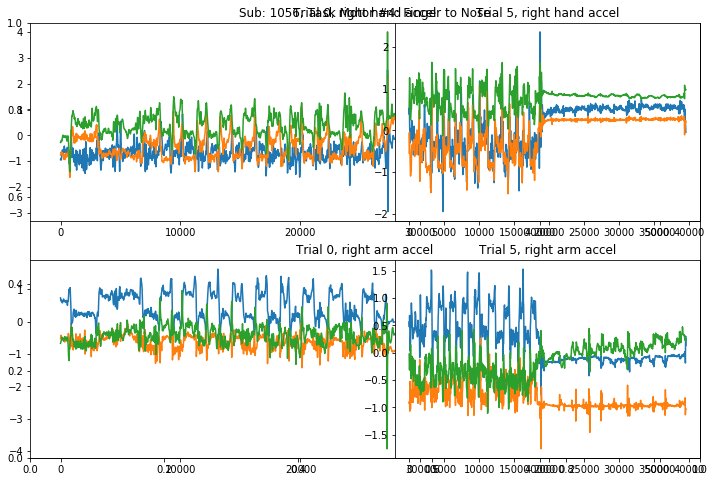

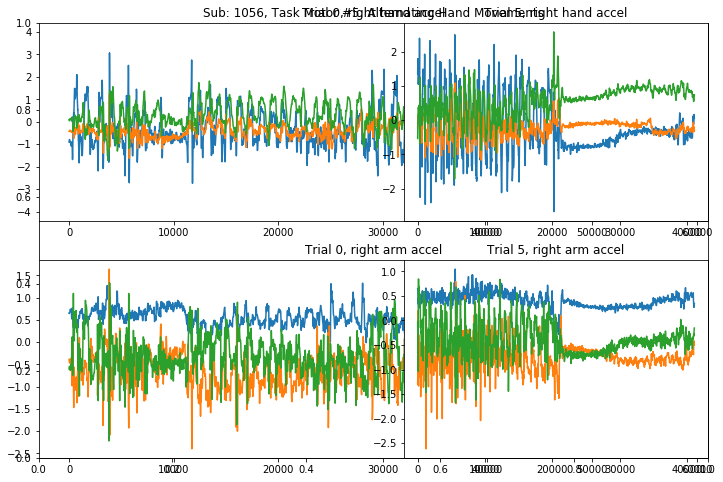

In [90]:
# task_list = ['Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
#            'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
#            'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
#            'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
#            'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
#            'Motor #12: Folding Towels', 'Motor #13: Sitting']

task_list = ['Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements']

subs = 1056
f = open(os.path.join(dict_path, str(subs) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

keys = list(act_dict[tasks].keys())

for tasks in task_list:
    fig = plt.figure(figsize=(12,8))
    plt.title('Sub: %s, Task %s'%(subs,tasks))
    fig.add_subplot(211)
    rawdata = act_dict[tasks][keys[0]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[0])

    fig.add_subplot(212)
    rawdata = act_dict[tasks][keys[0]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[0])

    fig.add_subplot(222)
    rawdata = act_dict[tasks][keys[-1]]['dorsal_hand_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right hand accel'%keys[-1])

    fig.add_subplot(224)
    rawdata = act_dict[tasks][keys[-1]]['flexor_digitorum_right']['accel']
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    plt.plot(rawdata); plt.title('Trial %d, right arm accel'%keys[-1])

In [7]:
df_new = pd.read_csv(os.path.join(features_path, 'Data_New.csv'))
df_old = pd.read_csv(os.path.join(features_path, 'Data_Old.csv'))

In [35]:
x = df_new.iloc[:28499,7:].values - df_old.iloc[:28499,7:].values

In [12]:
df_new.head()

Unnamed: 0  Subject            Visit               Task          Location  \
0           0     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   
1           1     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   
2           2     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   
3           3     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   
4           4     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   

   Bradykinesia  Tremor      RMSX      RMSY      RMSZ    ...      PSD_std  \
0           1.0     0.0  0.007757  0.010663  0.006639    ...     0.001943   
1           1.0     0.0  0.007055  0.010101  0.006168    ...     0.001101   
2           1.0     0.0  0.006322  0.009817  0.005220    ...     0.001917   
3           1.0     0.0  0.006983  0.011068  0.006131    ...     0.000871   
4           1.0     0.0  0.007013  0.009956  0.007715    ...     0.000949   

   PSD_skew    PSD_kur  jerk_mean  jerk_std  jerk_skew   jerk_kur     Sen_X  \
0  3.019358   8.685826   0.000318  0.039815  -0.184625  12.745926  0.632860   
1  2.173485   4.459587   0.000191  0.025149  -0.091885   0.860041  0.621925   
2  3.278183  11.718821  -0.000579  0.022814  -0.413633   1.497928  0.610420   
3  2.330253   7.034593  -0.000684  0.022869  -0.241547   0.774934  0.618093   
4  1.976281   3.120796   0.000467  0.031440  -1.066651   8.795971  0.687138   

      Sen_Y     Sen_Z  
0  0.662610  0.612830  
1  0.629151  0.538592  
2  0.607326  0.560962  
3  0.523065  0.499354  
4  0.649458  0.533576  

[5 rows x 44 columns]

In [11]:
new_list = np.unique(df_new.Subject)
print(new_list)
old_list = np.unique(df_old.Subject)
print(old_list)

[1004 1016 1018 1019 1020 1024 1029 1030 1032 1038 1044 1046 1047 1049
 1051 1052 1053 1054 1055 1056]
[1004 1016 1018 1019 1020 1024 1029 1030 1032 1038 1044 1046 1047 1049
 1051]


In [27]:
np.shape(df_new[df_new.Subject == 1004])

(1672, 44)

In [90]:
# Calculate number of clips for new data

columns = ['Subject', 'Task', 'Location', 'Clips']
ii = 0
dataframe_new = pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)

for subjects in np.unique(df_old.Subject):
    df_temp_sub = df_new[df_new.Subject == subjects]
    
    for activities in np.unique(df_temp_sub.Task):
        df_temp_act = df_temp_sub[df_temp_sub.Task == activities]
    
        for sensors in np.unique(df_temp_act.Location):
            df_temp = df_temp_act[df_temp_act.Location == sensors]
            num_clips = np.shape(df_temp)[0]
            
            df = pd.DataFrame(data={'Subject': subjects, 'Task': activities, 'Location': sensors, 'Clips': num_clips},
                              columns=columns, index=[ii])
            ii += 1
            dataframe_new = dataframe_new.append(df)            

In [91]:
# Calculate number of clips for old data

columns = ['Subject', 'Task', 'Location', 'Clips']
ii = 0
dataframe_old = pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)

for subjects in np.unique(df_old.Subject):
    df_temp_sub = df_old[df_old.Subject == subjects]
    
    for activities in np.unique(df_temp_sub.Task):
        df_temp_act = df_temp_sub[df_temp_sub.Task == activities]
    
        for sensors in np.unique(df_temp_act.Location):
            df_temp = df_temp_act[df_temp_act.Location == sensors]
            num_clips = np.shape(df_temp)[0]
            
            df = pd.DataFrame(data={'Subject': subjects, 'Task': activities, 'Location': sensors, 'Clips': num_clips},
                              columns=columns, index=[ii])
            ii += 1
            dataframe_old = dataframe_old.append(df)

In [92]:
dataframe_new.head()

Subject                          Task           Location  Clips
0   1004.0     Motor #10: Drinking Water   dorsal_hand_left   70.0
1   1004.0     Motor #10: Drinking Water  dorsal_hand_right   70.0
2   1004.0  Motor #11: Organizing Folder   dorsal_hand_left   80.0
3   1004.0  Motor #11: Organizing Folder  dorsal_hand_right   80.0
4   1004.0     Motor #12: Folding Towels   dorsal_hand_left   57.0

In [93]:
dataframe_old.head()

Subject                          Task           Location  Clips
0   1004.0     Motor #10: Drinking Water   dorsal_hand_left   70.0
1   1004.0     Motor #10: Drinking Water  dorsal_hand_right   70.0
2   1004.0  Motor #11: Organizing Folder   dorsal_hand_left   80.0
3   1004.0  Motor #11: Organizing Folder  dorsal_hand_right   80.0
4   1004.0     Motor #12: Folding Towels   dorsal_hand_left   57.0

In [101]:
dataframe_compare = pd.concat([dataframe_old, dataframe_new.Clips],keys=['old','new'],axis=1)
dataframe_compare.head()

old                                                          new
  Subject                          Task           Location Clips Clips
0  1004.0     Motor #10: Drinking Water   dorsal_hand_left  70.0  70.0
1  1004.0     Motor #10: Drinking Water  dorsal_hand_right  70.0  70.0
2  1004.0  Motor #11: Organizing Folder   dorsal_hand_left  80.0  80.0
3  1004.0  Motor #11: Organizing Folder  dorsal_hand_right  80.0  80.0
4  1004.0     Motor #12: Folding Towels   dorsal_hand_left  57.0  57.0

In [116]:
index_diff = dataframe_compare.old.Clips != dataframe_compare.new.Clips

df_difference = pd.DataFrame(dataframe_compare[index_diff].old.Clips - dataframe_compare[index_diff].new.Clips)

<class 'pandas.core.frame.DataFrame'>


In [122]:
df_final = pd.concat([dataframe_old[index_diff], dataframe_new.Clips[index_diff], df_difference],keys=['old','new','diff'],axis=1)
df_final

old                                                                  \
    Subject                                  Task           Location  Clips   
10   1004.0              Motor #4: Finger to Nose   dorsal_hand_left   85.0   
12   1004.0  Motor #5: Alternating Hand Movements   dorsal_hand_left  162.0   
13   1004.0  Motor #5: Alternating Hand Movements  dorsal_hand_right  160.0   
32   1016.0              Motor #4: Finger to Nose   dorsal_hand_left   45.0   
34   1016.0  Motor #5: Alternating Hand Movements   dorsal_hand_left   84.0   
35   1016.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   82.0   
54   1018.0              Motor #4: Finger to Nose   dorsal_hand_left   47.0   
56   1018.0  Motor #5: Alternating Hand Movements   dorsal_hand_left   88.0   
57   1018.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   82.0   
78   1019.0  Motor #5: Alternating Hand Movements   dorsal_hand_left   92.0   
79   1019.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   84.0   
88   1020.0             Motor #10: Drinking Water   dorsal_hand_left   13.0   
89   1020.0             Motor #10: Drinking Water  dorsal_hand_right   13.0   
90   1020.0          Motor #11: Organizing Folder   dorsal_hand_left   14.0   
91   1020.0          Motor #11: Organizing Folder  dorsal_hand_right   14.0   
92   1020.0             Motor #12: Folding Towels   dorsal_hand_left   12.0   
93   1020.0             Motor #12: Folding Towels  dorsal_hand_right   12.0   
94   1020.0                     Motor #2: Walking   dorsal_hand_left   13.0   
95   1020.0                     Motor #2: Walking  dorsal_hand_right   13.0   
96   1020.0      Motor #3: Walking while Counting   dorsal_hand_left   13.0   
97   1020.0      Motor #3: Walking while Counting  dorsal_hand_right   13.0   
98   1020.0              Motor #4: Finger to Nose   dorsal_hand_left    6.0   
99   1020.0              Motor #4: Finger to Nose  dorsal_hand_right    6.0   
100  1020.0  Motor #5: Alternating Hand Movements   dorsal_hand_left   12.0   
101  1020.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   12.0   
102  1020.0                Motor #6: Sit to Stand   dorsal_hand_left    6.0   
103  1020.0                Motor #6: Sit to Stand  dorsal_hand_right    6.0   
104  1020.0            Motor #7: Drawing on Paper   dorsal_hand_left   13.0   
105  1020.0            Motor #7: Drawing on Paper  dorsal_hand_right   13.0   
106  1020.0        Motor #8: Typing on a Computer   dorsal_hand_left   14.0   
..      ...                                   ...                ...    ...   
123  1024.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   72.0   
142  1029.0              Motor #4: Finger to Nose   dorsal_hand_left   48.0   
144  1029.0  Motor #5: Alternating Hand Movements   dorsal_hand_left   90.0   
145  1029.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   86.0   
164  1030.0              Motor #4: Finger to Nose   dorsal_hand_left   50.0   
166  1030.0  Motor #5: Alternating Hand Movements   dorsal_hand_left   98.0   
167  1030.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   92.0   
186  1032.0              Motor #4: Finger to Nose   dorsal_hand_left   49.0   
188  1032.0  Motor #5: Alternating Hand Movements   dorsal_hand_left  104.0   
189  1032.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   96.0   
208  1038.0              Motor #4: Finger to Nose   dorsal_hand_left   50.0   
210  1038.0  Motor #5: Alternating Hand Movements   dorsal_hand_left   92.0   
211  1038.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   88.0   
230  1044.0              Motor #4: Finger to Nose   dorsal_hand_left   46.0   
232  1044.0  Motor #5: Alternating Hand Movements   dorsal_hand_left  102.0   
233  1044.0  Motor #5: Alternating Hand Movements  dorsal_hand_right   96.0   
252  1046.0              Motor #4: Finger to Nose   dorsal_hand_left   43.0   
254  1046.0  Motor #5: Alternating Hand Movements   dorsal

In [123]:
df_final.to_csv(os.path.join(folder_path,'ClipsDiff.csv'))

In [125]:
folder_path

'D:\\CIS-PD Study'

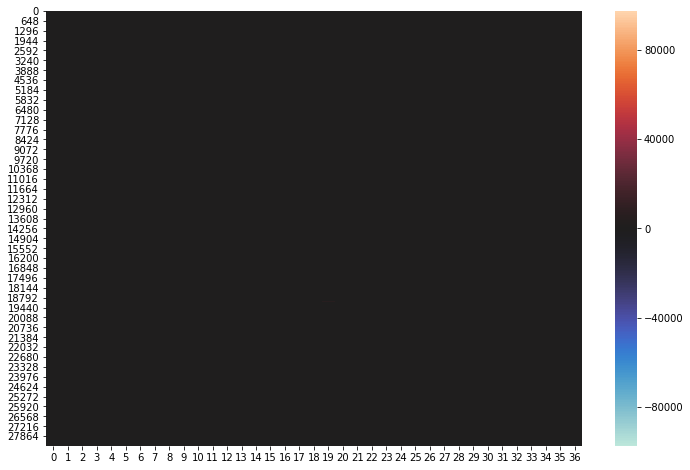

In [65]:
plt.figure(figsize=(12,8))
sns.heatmap(x,center=0)

In [79]:
np.percentile(x,90)

1.262990202028809

In [83]:
np.sum(x!=0)

1053979

{'boxes': [<matplotlib.lines.Line2D at 0x27d83ffa940>],
 'caps': [<matplotlib.lines.Line2D at 0x27d84007390>,
 'fliers': [<matplotlib.lines.Line2D at 0x27d8401c048>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x27d84007be0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x27d83ffaa90>,
  <matplotlib.lines.Line2D at 0x27d83ffaf28>]}

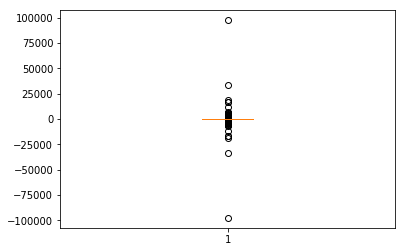

In [47]:
plt.boxplot(x.ravel())

In [67]:
np.sum(x,axis=0)

array([-3.11435367e+01, -2.10996161e+00, -2.45031702e+01, -1.87632145e+03,
       -5.20996739e+01, -1.49854341e+03,  4.20340411e-01, -4.25573312e-02,
       -6.62928494e-02, -5.49362781e+02, -3.71297464e+01, -4.32248553e+02,
       -1.29965168e+02, -3.18399968e+01,  3.70417184e+02,  3.95104989e+03,
        2.77997948e+03,  4.46760797e+03,  1.94100009e+03,  6.49608788e+03,
        1.45644365e+03,  1.02623664e+01, -7.73127326e+00, -7.90774308e+00,
       -9.23429332e+02,  1.09678268e+01, -1.09506181e+01, -2.06334781e+01,
       -6.51123113e+01, -3.20624466e+02, -9.44906773e-02, -9.73475312e+01,
        3.34457866e+02,  6.56462420e+03,  2.94678325e+02, -7.70614098e+01,
        2.91585684e+02])

In [54]:
m = (np.max(x,axis=0))
np.where(m>10)

(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 29, 32, 33], dtype=int64),)

In [51]:
df_new.columns[7:]

Index(['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX', 'meanY',
       'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ', 'kurtX',
       'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ',
       'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq', 'Pdom_rel',
       'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean', 'jerk_std',
       'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z'],
      dtype='object')